Draft to measure emmsion lines. Make model line, convolve model by appropriate lsf, fit to spectrum.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from scipy.interpolate import interpolate
from craftroom import resample
from astropy.convolution import convolve, Box1DKernel
from astropy.modeling import models, fitting
from scipy.optimize import leastsq
from astropy.modeling import functional_models

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20


In [2]:
path = '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/'

In [3]:
hdul = fits.open('{}hlsp_muscles_multi_multi_gj674_broadband_v1_var-res-sed.fits'.format(path))

In [12]:
data = hdul[1].data
inst_list = hdul[2].data
inst_list

FITS_rec([(      1, 'HST', 'COS', 'G130M', 'hlsp_muscles_hst_cos_gj674_g130m_v1_component-spec.fits'),
          (  65536, 'MOD', 'LYA', 'YOUNG', 'hlsp_muscles_mod_lya_gj674_young_v1_component-spec.fits'),
          (      8, 'HST', 'STS', 'G140M', 'hlsp_muscles_hst_sts_gj674_g140m_v1_component-spec.fits'),
          (8388608, 'HST', 'STS', 'G140L', 'hlsp_muscles_hst_sts_gj674_g140l_v1_component-spec.fits'),
          (    128, 'HST', 'STS', 'G230L', 'hlsp_muscles_hst_sts_gj674_g230l_v1_component-spec.fits'),
          ( 131072, 'MOD', 'PHX', 'NA', 'hlsp_muscles_mod_phx_gj674_na_v1_component-spec.fits'),
          (    256, 'HST', 'STS', 'G430L', 'hlsp_muscles_hst_sts_gj674_g430l_v1_component-spec.fits'),
          ( 131072, 'MOD', 'PHX', 'NA', 'hlsp_muscles_mod_phx_gj674_na_v1_component-spec.fits'),
          (   2048, 'XMM', 'EPC', 'MULTI', 'hlsp_muscles_xmm_epc_gj674_multi_v1_component-spec.fits'),
          (  32768, 'MOD', 'APC', 'NA', 'hlsp_muscles_mod_apc_gj674_na_v1_component-s

In [13]:
mask = (data['WAVELENGTH'] > 1160) & (data['WAVELENGTH'] < 2000) & (data['INSTRUMENT'] != 65536)

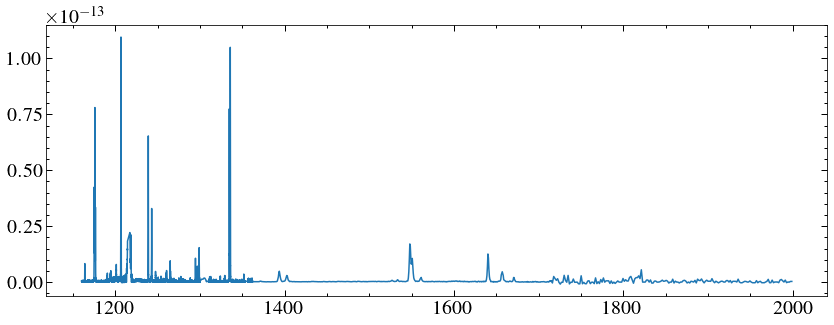

In [14]:
plt.plot(data['WAVELENGTH'][mask], data['FLUX'][mask])

In [15]:
line_list = Table.read('FUV_linelist.csv')

(1160.0, 1700.0)

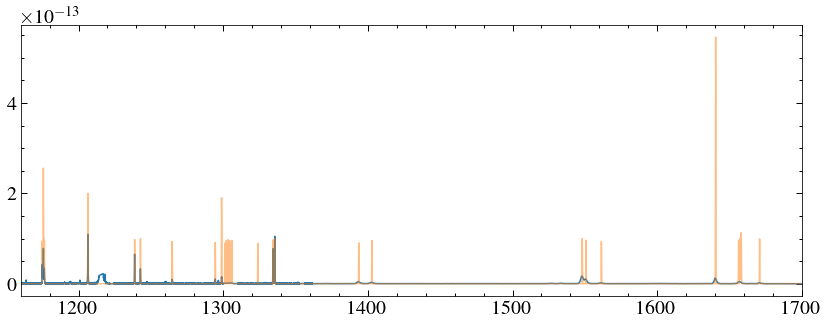

In [46]:
mod1 = models.Const1D(0)
for i in range(len(line_list)):
    amp = 1e-13
#     if line_list['Likelihood to measure'][i] == 'Low':
#         amp = amp/3
#     if line_list['Likelihood to measure'][i] == 'Medium':
#         amp = amp/2
    if line_list['Likelihood to measure'][i] == 'High':
#     mod1 = mod1+ functional_models.Voigt1D(x_0=line_list['Wavelength'][i], amplitude_L=amp, fwhm_G=0.05, fwhm_L=0.05)
        mod1 = mod1 + models.Gaussian1D(amplitude=amp, mean = line_list['Wavelength'][i], stddev=0.1)


mw = np.arange(900, 1700, 0.1)
plt.plot(data['WAVELENGTH'][mask], data['FLUX'][mask])
plt.plot(mw, mod1(mw), alpha=0.5)
plt.xlim(1160, 1700)


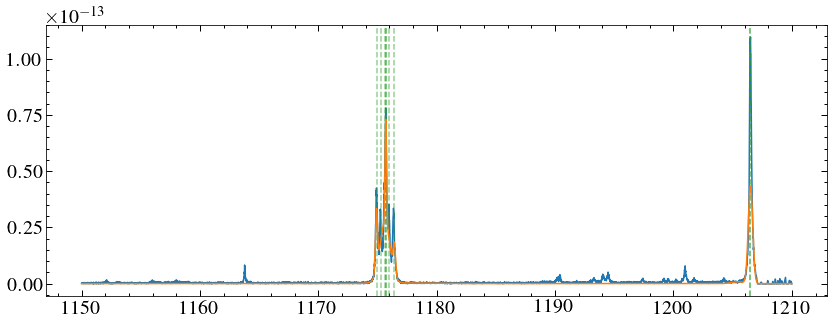

/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/astropy/modeling/fitting.py:894: RuntimeWarning: invalid value encountered in multiply
  return np.ravel(weights * (model(*args[2: -1]) - meas))


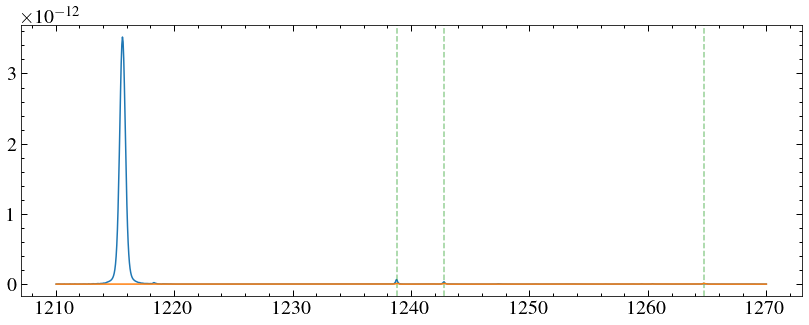

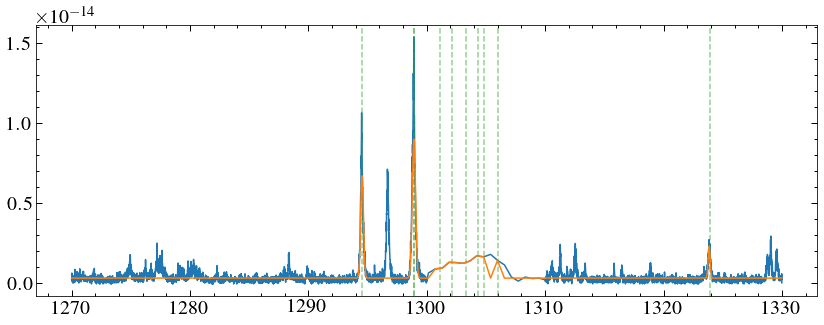

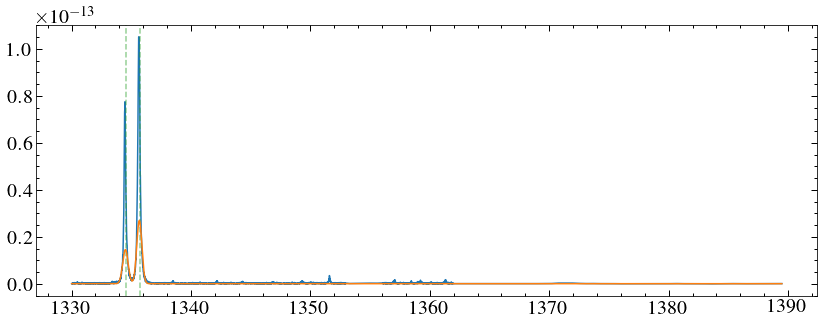

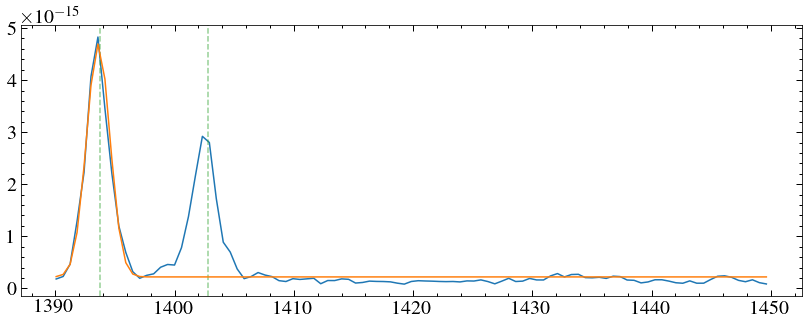

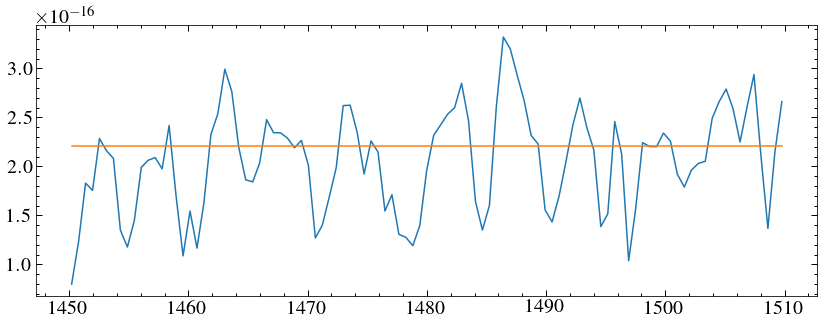

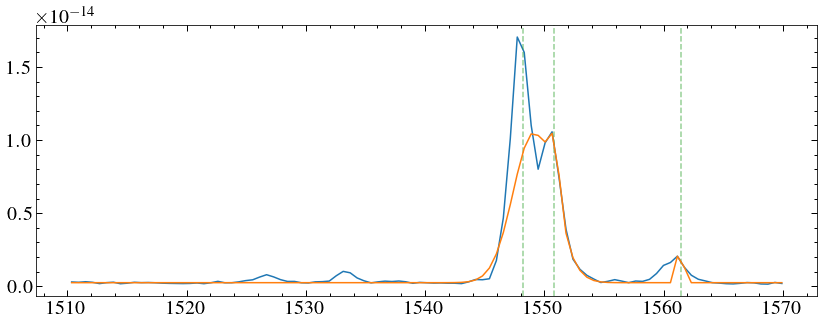

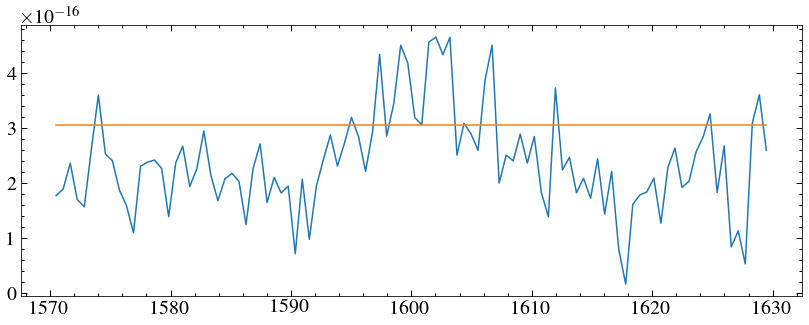

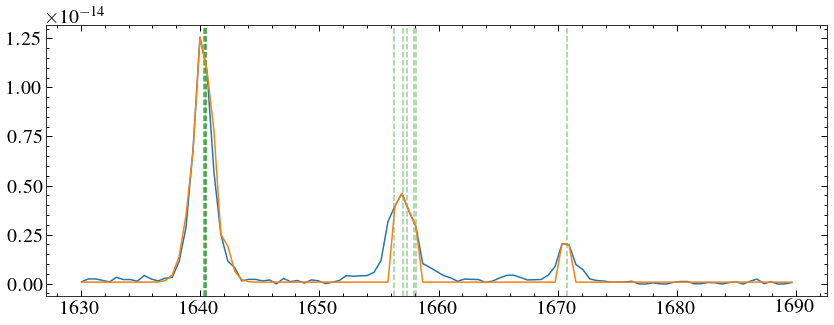

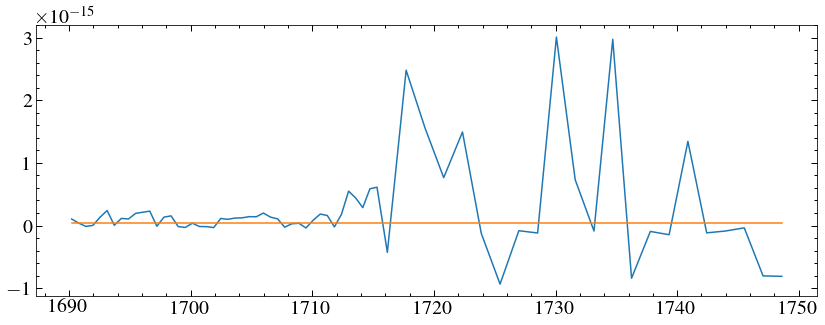

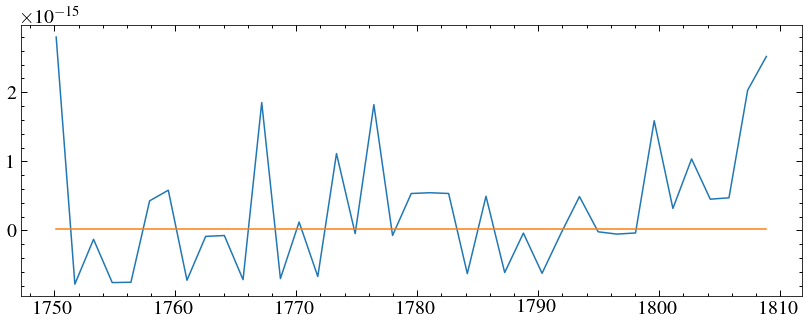

In [63]:
#50 AA chunks?
fitter = fitting.LevMarLSQFitter()
start = 1150
step = 60
w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
lines = line_list[line_list['Likelihood to measure'] == 'High']['Wavelength']

while start < 1800:
    mask = (w > start) & (w <= start+step)
    plt.plot(w[mask], f[mask])
    lmask = (lines > start) & (lines <=start+step)
    mod = models.Const1D(0)
    for line in lines[lmask]:
#         mod = mod + functional_models.Voigt1D(x_0=line, amplitude_L=1e-14, fwhm_G=0.05, fwhm_L=0.05)
        mod = mod+  models.Gaussian1D(amplitude=1e-14, mean = line, stddev=0.1)
        plt.axvline(line, ls='--', c='C2', alpha =0.5)
    gg_fit = fitter(mod, w[mask], f[mask], weights = 1/e[mask], maxiter=1000)
    plt.plot(w[mask], gg_fit(w[mask]))
    plt.show()
    start += step
    